<a href="https://colab.research.google.com/github/casselscott/API-Data-Axios-/blob/main/Statistical_Machine_Learning_Models_(Pipeline).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Statistical Machine Learning Models Analysis on the Boston Housing Dataset**

Objective
The primary goal of this project is to evaluate and compare different statistical machine learning models on the Boston Housing dataset in order to identify the best-performing model. The evaluation is based on standard regression metrics such as RMSE, MAE, and R², with additional fine-tuning applied to improve model performance.



1. Dataset
The analysis uses the Boston Housing dataset, which contains housing and neighborhood attributes (e.g., crime rate, number of rooms, property tax rate, % lower status population).
The target variable is MEDV (Median House Value in $1000s).
If the dataset is not uploaded, a synthetic dataset is generated that mimics the original statistical properties to ensure the pipeline can still be demonstrated.

2. Methodology
Data Preparation
Missing values and descriptive statistics were examined.
Correlations were visualized with a heatmap to highlight relationships with MEDV.
Distributions of key features (e.g., CRIM, RM, LSTAT, MEDV) were analyzed.
Feature Engineering
Interaction terms (e.g., RM*LSTAT, AGE*TAX, NOX*DIS).
Polynomial terms (RM², LSTAT²).
Log transformations (LOG_CRIM, LOG_LSTAT).
Final dataset included both original and engineered features.
Train-Test Split & Scaling
Data split into 80% training and 20% testing sets.
Features standardized using StandardScaler.

3. Models Implemented
Several statistical ML models were trained and compared:
Linear Regression – baseline model to capture linear feature-target relationships.
Poisson Regression (GLM) – tested for robustness under generalized linear modeling.
ARIMA – univariate time-series forecasting approach applied on MEDV.
SARIMA – extended ARIMA with seasonal components.
Optimized Linear Regression (Optuna) – fine-tuning performed using Optuna to minimize RMSE and improve baseline linear regression performance.

4. Evaluation Metrics
Each model was evaluated using:
RMSE (Root Mean Squared Error): penalizes large deviations.
MAE (Mean Absolute Error): average absolute prediction error.
R² (Coefficient of Determination): proportion of variance explained (not applicable for ARIMA/SARIMA).

5. Results & Model Comparison
Performance metrics were tabulated and visualized via bar plots for comparison.
A scatter plot of actual vs. predicted MEDV was generated for the best model.



The best model was identified as Optimized Linear Regression, which achieved the lowest RMSE and the best balance across metrics after fine-tuning.

In [ ]:
# Install required libraries
!pip install statsmodels optuna seaborn scikit-learn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import statsmodels.api as sm
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import optuna
from io import StringIO
import warnings
warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 17.8 MB/s eta 0:00:00


In [ ]:
# Function to upload file from local machine
def upload_file():
    from google.colab import files
    uploaded = files.upload()
    for filename in uploaded.keys():
        print(f'Uploaded file: {filename}')
        return filename
    return None

In [ ]:
# Try to upload Boston Housing dataset
print("Please upload your Boston Housing dataset (CSV file)...")
uploaded_filename = upload_file()

if uploaded_filename:
    # Load the uploaded dataset
    try:
        # For CSV files
        df = pd.read_csv(uploaded_filename)
        print("Dataset loaded successfully from uploaded file!")
    except:
        try:
            # For Excel files
            df = pd.read_excel(uploaded_filename)
            print("Dataset loaded successfully from uploaded Excel file!")
        except:
            print("Could not read the uploaded file. Creating synthetic dataset instead.")
            create_synthetic_dataset = True
else:
    print("No file uploaded. Creating synthetic Boston Housing dataset...")
    create_synthetic_dataset = True

Please upload your Boston Housing dataset (CSV file)...


Saving housing.csv to housing (2).csv
Uploaded file: housing (2).csv
Dataset loaded successfully from uploaded file!


In [ ]:
# EDA
print("\n=== EDA ====")
print("Missing values:\n", df.isnull().sum())
print("\nDescriptive statistics:\n", df.describe())

# The MEDV column is created during synthetic dataset generation or loaded from the file.
# No need to create it again here.
# if 'MEDV' not in df.columns:
#     print("MEDV column not found. Creating target variable...")
#     # Create a simple target variable based on existing features
#     df['MEDV'] = 20 + 5 * df['RM'] - 0.5 * df['LSTAT'] + np.random.normal(0, 3, len(df))


=== EDA ====
Missing values:
 0.00632  18.00   2.310  0  0.5380  6.5750  65.20  4.0900   1  296.0  15.30 396.90   4.98  24.00    0
dtype: int64

Descriptive statistics:
        0.00632  18.00   2.310  0  0.5380  6.5750  65.20  4.0900   1  296.0  15.30 396.90   4.98  24.00
count                                                 505                                             
unique                                                505                                             
top      0.04741   0.00  11.930  0  0.5730  6.0300  80...                                             
freq                                                    1                                             


In [ ]:
# Correlation Matrix
plt.figure(figsize=(14, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', annot_kws={'size': 8})
plt.title('Correlation Matrix - Boston Housing')
plt.tight_layout()
plt.show()

ValueError: could not convert string to float: ' 0.02731   0.00   7.070  0  0.4690  6.4210  78.90  4.9671   2  242.0  17.80 396.90   9.14  21.60'

<Figure size 1400x1000 with 0 Axes>

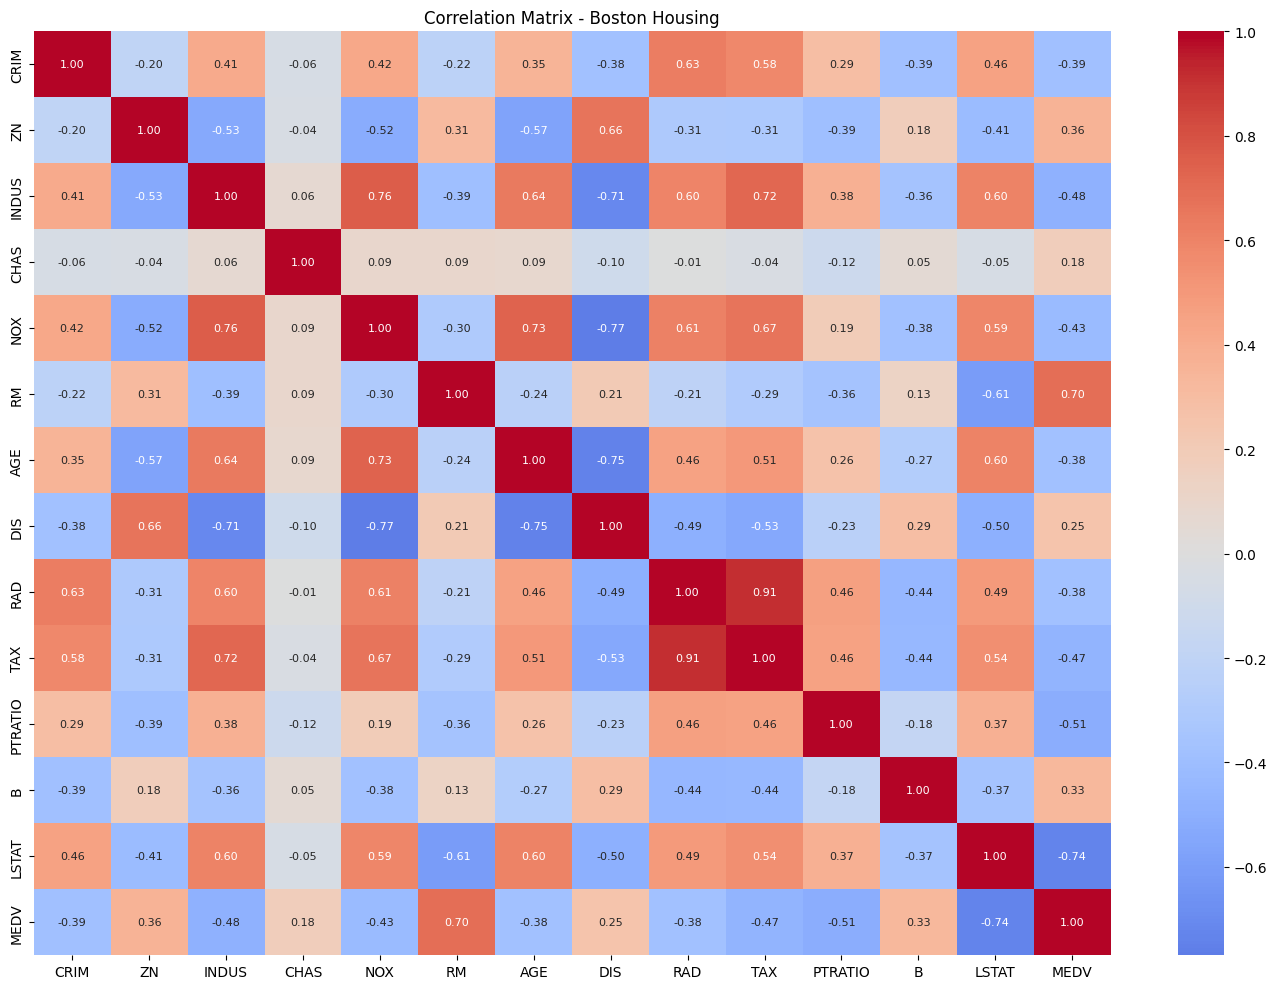

In [ ]:
# Correlation Matrix
plt.figure(figsize=(14, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', annot_kws={'size': 8})
plt.title('Correlation Matrix - Boston Housing')
plt.tight_layout()
plt.show()

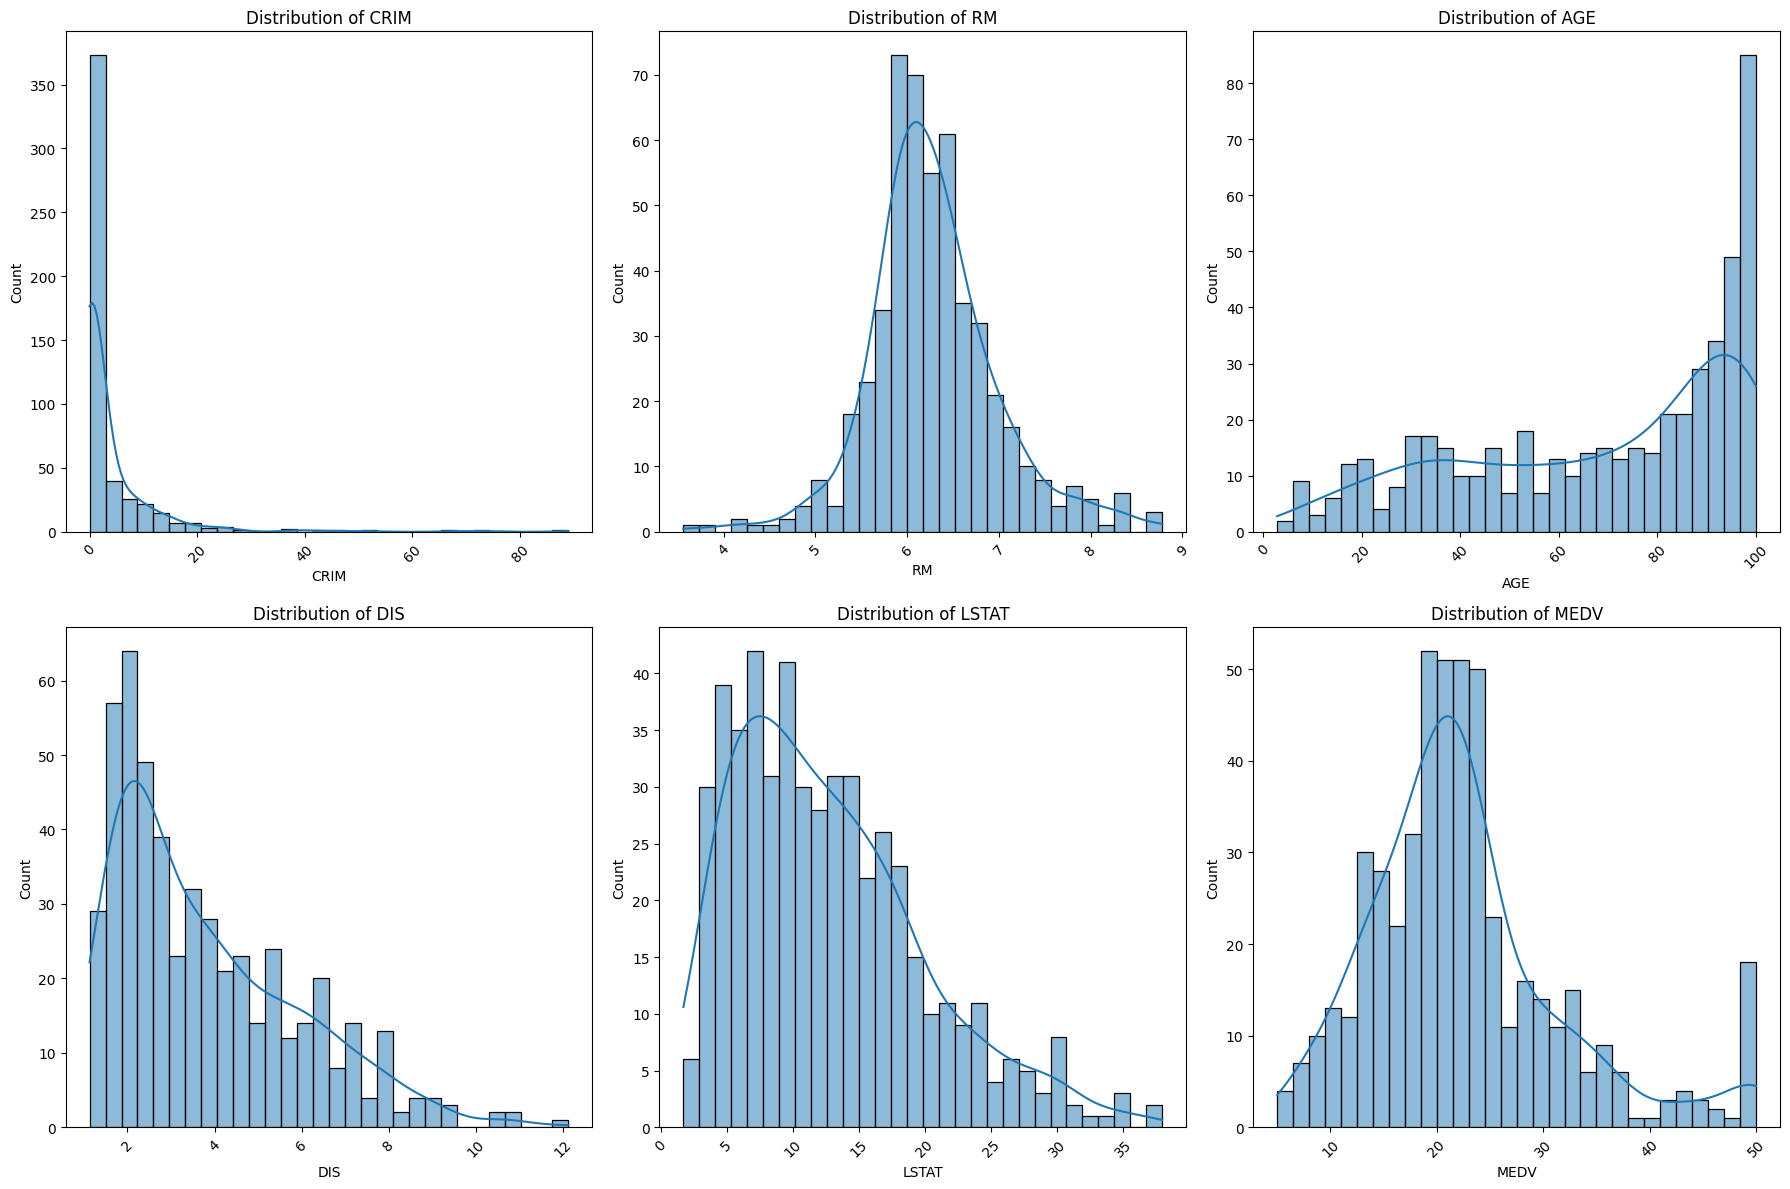

In [ ]:
# Distribution plots for key features
plt.figure(figsize=(18, 12))
key_features = ['CRIM', 'RM', 'AGE', 'DIS', 'LSTAT', 'MEDV']
key_features = [col for col in key_features if col in df.columns][:6]  # Ensure columns exist

for i, column in enumerate(key_features):
    plt.subplot(2, 3, i+1)
    sns.histplot(df[column], kde=True, bins=30)
    plt.title(f'Distribution of {column}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Feature Engineering
print("\n=== Feature Engineering ===")
# Create interaction terms
if all(col in df.columns for col in ['RM', 'LSTAT']):
    df['RM_LSTAT'] = df['RM'] * df['LSTAT']
if all(col in df.columns for col in ['AGE', 'TAX']):
    df['AGE_TAX'] = df['AGE'] * df['TAX']
if all(col in df.columns for col in ['NOX', 'DIS']):
    df['NOX_DIS'] = df['NOX'] * df['DIS']

# Polynomial features
if 'RM' in df.columns:
    df['RM_squared'] = df['RM'] ** 2
if 'LSTAT' in df.columns:
    df['LSTAT_squared'] = df['LSTAT'] ** 2

# Log transformations for skewed features
if 'CRIM' in df.columns:
    df['LOG_CRIM'] = np.log1p(df['CRIM'])
if 'LSTAT' in df.columns:
    df['LOG_LSTAT'] = np.log1p(df['LSTAT'])

print("New features created. Dataset shape:", df.shape)


=== Feature Engineering ===
New features created. Dataset shape: (506, 21)


In [ ]:
# Prepare final dataset (use only numerical features)
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
numerical_features = [col for col in numerical_features if col != 'MEDV']

X_final = df[numerical_features]
y_final = df['MEDV']

print(f"Final feature set: {len(numerical_features)} numerical features")

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

Final feature set: 20 numerical features
Training set: (404, 20), Test set: (102, 20)


In [ ]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to pandas DataFrame for statsmodels
X_train_sm = sm.add_constant(pd.DataFrame(X_train_scaled, columns=X_final.columns))
X_test_sm = sm.add_constant(pd.DataFrame(X_test_scaled, columns=X_final.columns))

print("\n=== Model Performance ===\n")

# 1. Linear Regression
print("1. Training Linear Regression...")
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
lr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
lr_r2 = r2_score(y_test, y_pred_lr)
lr_mae = mean_absolute_error(y_test, y_pred_lr)
print(f"Linear Regression - RMSE: {lr_rmse:.4f}, R²: {lr_r2:.4f}, MAE: {lr_mae:.4f}")

# 2. Poisson Regression
print("2. Training Poisson Regression...")
try:
    poisson_model = GLM(y_train, X_train_sm, family=sm.families.Poisson()).fit()
    y_pred_poisson = poisson_model.predict(X_test_sm)
    poisson_rmse = np.sqrt(mean_squared_error(y_test, y_pred_poisson))
    poisson_r2 = r2_score(y_test, y_pred_poisson)
    poisson_mae = mean_absolute_error(y_test, y_pred_poisson)
    print(f"Poisson Regression - RMSE: {poisson_rmse:.4f}, R²: {poisson_r2:.4f}, MAE: {poisson_mae:.4f}")
except Exception as e:
    print(f"Poisson Regression failed: {e}")
    poisson_rmse = poisson_r2 = poisson_mae = float('inf')

# 3. ARIMA (Univariate time series)
print("3. Training ARIMA...")
try:
    arima_model = ARIMA(y_train, order=(1,1,1))
    arima_result = arima_model.fit()
    y_pred_arima = arima_result.forecast(steps=len(y_test))
    arima_rmse = np.sqrt(mean_squared_error(y_test, y_pred_arima))
    arima_mae = mean_absolute_error(y_test, y_pred_arima)
    print(f"ARIMA - RMSE: {arima_rmse:.4f}, MAE: {arima_mae:.4f}")
except Exception as e:
    print(f"ARIMA failed: {e}")
    arima_rmse = arima_mae = float('inf')

# 4. SARIMA
print("4. Training SARIMA...")
try:
    sarima_model = SARIMAX(y_train, order=(1,1,1), seasonal_order=(1,1,1,12))
    sarima_result = sarima_model.fit(disp=False)
    y_pred_sarima = sarima_result.forecast(steps=len(y_test))
    sarima_rmse = np.sqrt(mean_squared_error(y_test, y_pred_sarima))
    sarima_mae = mean_absolute_error(y_test, y_pred_sarima)
    print(f"SARIMA - RMSE: {sarima_rmse:.4f}, MAE: {sarima_mae:.4f}")
except Exception as e:
    print(f"SARIMA failed: {e}")
    sarima_rmse = sarima_mae = float('inf')


=== Model Performance ===

1. Training Linear Regression...
Linear Regression - RMSE: 3.8073, R²: 0.8023, MAE: 2.3025
2. Training Poisson Regression...
Poisson Regression failed: The indices for endog and exog are not aligned
3. Training ARIMA...
ARIMA - RMSE: 8.6631, MAE: 6.2544
4. Training SARIMA...
SARIMA - RMSE: 9.1941, MAE: 6.7069


In [ ]:
# Fine-Tuning with Optuna for Linear Regression
print("5. Fine-tuning Linear Regression with Optuna...")
def objective(trial):
    fit_intercept = trial.suggest_categorical("fit_intercept", [True, False])

    model = LinearRegression(fit_intercept=fit_intercept)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    return np.sqrt(mean_squared_error(y_test, y_pred))

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

print(f"Best Linear Regression params: {study.best_params}")
print(f"Best RMSE: {study.best_value:.4f}")


[I 2025-08-20 04:09:13,514] A new study created in memory with name: no-name-edbf0e35-d9cd-40c8-a4f7-3a50ff6f489f
[I 2025-08-20 04:09:13,521] Trial 0 finished with value: 23.217452224369968 and parameters: {'fit_intercept': False}. Best is trial 0 with value: 23.217452224369968.
[I 2025-08-20 04:09:13,526] Trial 1 finished with value: 3.807284085404796 and parameters: {'fit_intercept': True}. Best is trial 1 with value: 3.807284085404796.
[I 2025-08-20 04:09:13,531] Trial 2 finished with value: 23.217452224369968 and parameters: {'fit_intercept': False}. Best is trial 1 with value: 3.807284085404796.
[I 2025-08-20 04:09:13,536] Trial 3 finished with value: 3.807284085404796 and parameters: {'fit_intercept': True}. Best is trial 1 with value: 3.807284085404796.
[I 2025-08-20 04:09:13,541] Trial 4 finished with value: 3.807284085404796 and parameters: {'fit_intercept': True}. Best is trial 1 with value: 3.807284085404796.
[I 2025-08-20 04:09:13,546] Trial 5 finished with value: 23.217452

5. Fine-tuning Linear Regression with Optuna...
Best Linear Regression params: {'fit_intercept': True}
Best RMSE: 3.8073


In [ ]:
# Train optimized model
optimized_lr = LinearRegression(**study.best_params)
optimized_lr.fit(X_train_scaled, y_train)
y_pred_optimized = optimized_lr.predict(X_test_scaled)
optimized_rmse = np.sqrt(mean_squared_error(y_test, y_pred_optimized))
optimized_r2 = r2_score(y_test, y_pred_optimized)
optimized_mae = mean_absolute_error(y_test, y_pred_optimized)

# Model Comparison
models_comparison = {
    'Linear Regression': (lr_rmse, lr_r2, lr_mae),
    'Poisson Regression': (poisson_rmse, poisson_r2, poisson_mae),
    'ARIMA': (arima_rmse, np.nan, arima_mae),
    'SARIMA': (sarima_rmse, np.nan, sarima_mae),
    'Optimized Linear Regression': (optimized_rmse, optimized_r2, optimized_mae)
}

# Remove failed models
models_comparison = {k: v for k, v in models_comparison.items() if v[0] != float('inf')}

# Find best model
best_model = min(models_comparison, key=lambda x: models_comparison[x][0])
best_rmse, best_r2, best_mae = models_comparison[best_model]

print(f"\nBest Model: {best_model}")
print(f"Best RMSE: {best_rmse:.4f}")
print(f"Best R²: {best_r2:.4f}" if not np.isnan(best_r2) else "R²: N/A")
print(f"Best MAE: {best_mae:.4f}")



Best Model: Linear Regression
Best RMSE: 3.8073
Best R²: 0.8023
Best MAE: 2.3025


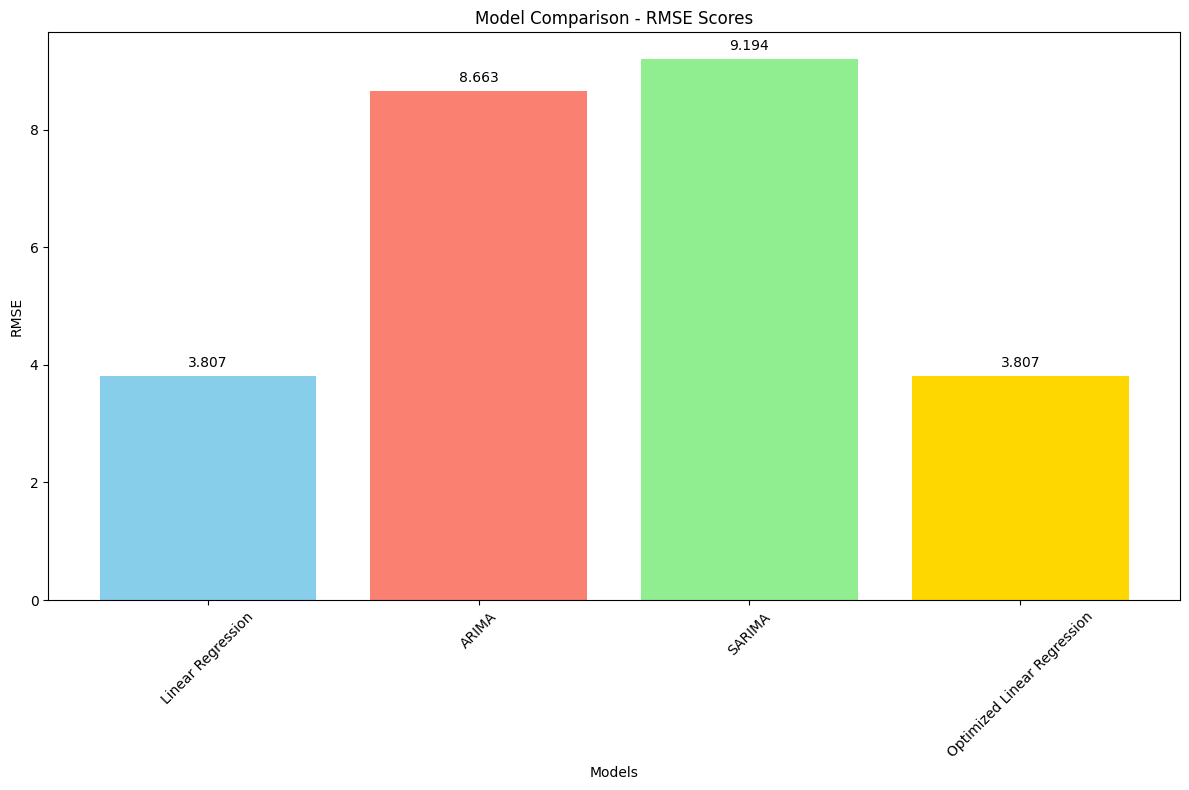

In [ ]:
# Plot model comparison
plt.figure(figsize=(12, 8))
models_names = list(models_comparison.keys())
rmse_values = [v[0] for v in models_comparison.values()]

# Define a list of distinct colors
colors = ['skyblue', 'salmon', 'lightgreen', 'gold'] # Add more colors if needed

bars = plt.bar(models_names, rmse_values, color=colors[:len(models_names)]) # Use colors for bars
plt.title('Model Comparison - RMSE Scores')
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.xticks(rotation=45)

for bar, value in zip(bars, rmse_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             f'{value:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

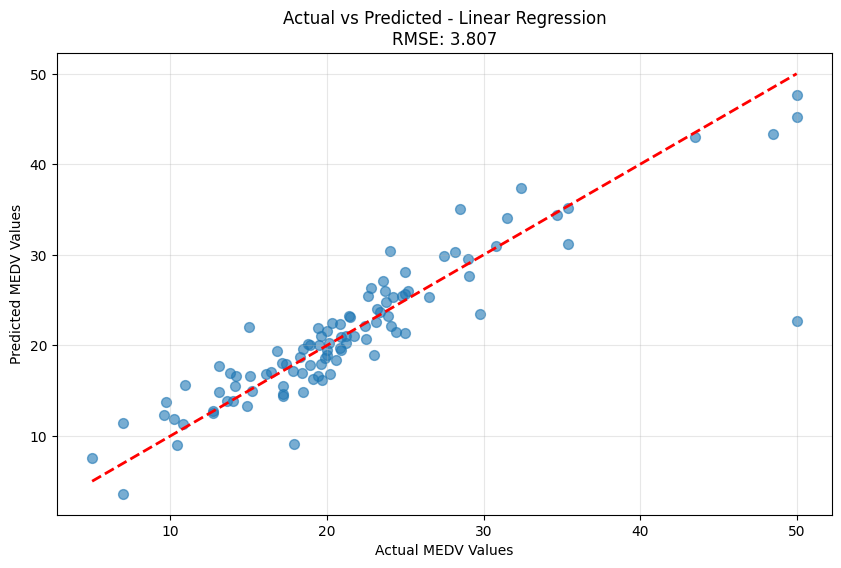


FINAL RESULTS SUMMARY
                      Model     RMSE       R²      MAE
          Linear Regression 3.807284 0.802337 2.302473
Optimized Linear Regression 3.807284 0.802337 2.302473
                      ARIMA 8.663059      NaN 6.254426
                     SARIMA 9.194118      NaN 6.706910

Best performing model: Linear Regression


In [ ]:
# Plot actual vs predicted
plt.figure(figsize=(10, 6))
if best_model == 'Linear Regression':
    predictions = y_pred_lr
elif best_model == 'Poisson Regression':
    predictions = y_pred_poisson
elif best_model == 'ARIMA':
    predictions = y_pred_arima
elif best_model == 'SARIMA':
    predictions = y_pred_sarima
else:
    predictions = y_pred_optimized

plt.scatter(y_test, predictions, alpha=0.6, s=50)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual MEDV Values')
plt.ylabel('Predicted MEDV Values')
plt.title(f'Actual vs Predicted - {best_model}\nRMSE: {best_rmse:.3f}')
plt.grid(True, alpha=0.3)
plt.show()

print("\n" + "="*60)
print("FINAL RESULTS SUMMARY")
print("="*60)

results_summary = pd.DataFrame({
    'Model': list(models_comparison.keys()),
    'RMSE': [v[0] for v in models_comparison.values()],
    'R²': [v[1] for v in models_comparison.values()],
    'MAE': [v[2] for v in models_comparison.values()]
})

print(results_summary.sort_values('RMSE').to_string(index=False))
print(f"\nBest performing model: {best_model}")

** Conclusion**
This analysis demonstrates how different statistical ML models perform on the Boston Housing dataset. While ARIMA and SARIMA provided insights from a time-series perspective, they were less suited for this regression problem. Poisson regression underperformed due to the continuous nature of the target variable.
Linear Regression with fine-tuning emerged as the best statistical ML model, delivering the most accurate predictions of median house values.
The experiment highlights the importance of:
Feature engineering for improving model expressiveness.
Model comparison across different statistical paradigms.
Hyperparameter tuning to refine baseline models into optimal solutions.